# 4. 설명 가능한 CNN
:사람이 이해할 수 있는 방식으로 처리 결과 제시

<h2> 1. 특성 맵 시각화 </h2>

In [3]:
#1) 필요한  라이브러리 호출
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#2) 설명 가능한 네트워크 생성
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), #inplace=True :: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.3),
            nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), #inplace=True :: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(128,128,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), #inplace=True :: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), #inplace=True :: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512,512,bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    #신경망 말단의 결괏값들을 확률 개념으로 해석하기 위해 log값을 취함
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        x = self.classifier(x)
        return F.log_softmax(x)
    

In [13]:
#3) 모델 객체화
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [14]:
#4) 특성 맵을 확인하기 위한 클래스 정의
class LaterActivations :
    features = []
    def __init__(self, model, layer_num):
        #파이토치는 매 계층마다 print문을 사용하지 않더라도 hook 기능을 사용하여 각 계층의 활성화 함수 및 기울기 값을 확인할 수 있음
        self.hook = model[layer_num].register_forward_hook(self.hook_fn) 
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
        
    def remove(self) : #hook 삭제
        self.hook.remove()

torch.Size([1, 3, 100, 100])


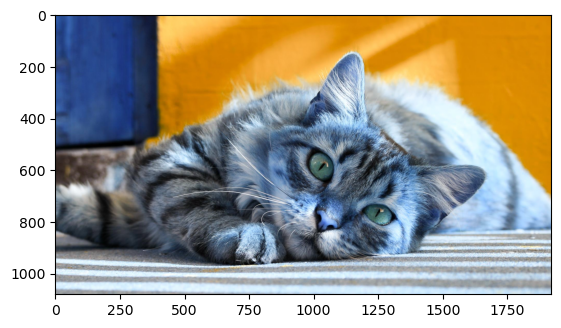

In [15]:
#5) 이미지 호출
img = cv2.imread('../data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img,(100,100), interpolation=cv2.INTER_LINEAR) #이미지 크기 변경
img = ToTensor()(img).unsqueeze(0) #1차원 데이터를 생성하는 함수
print(img.shape)

In [16]:
#6) Conv2d 특성 맵 확인
result = LaterActivations(model.features, 0)#0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

C:\Users\lockd\AppData\Local\Temp\ipykernel_42028\1668015206.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


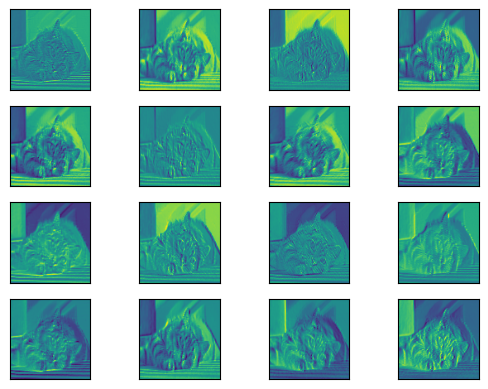

<Figure size 1200x800 with 0 Axes>

In [19]:
#7)특성맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [20]:
#8) 20번째 계층에 대한 특성 맵
result = LaterActivations(model.features, 20) #20번째 Conv2d 특성 맵 확인
model(img)
activations = result.features

C:\Users\lockd\AppData\Local\Temp\ipykernel_42028\1668015206.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


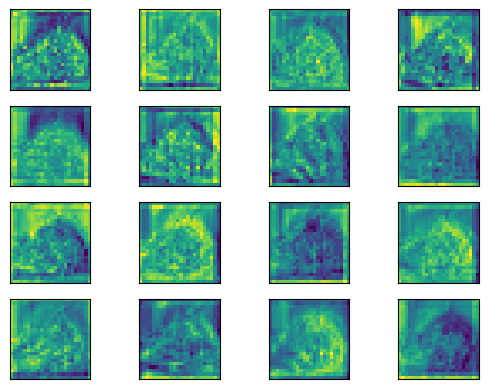

<Figure size 1200x800 with 0 Axes>

In [23]:
#9) 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [24]:
#10) 40번째 계층에 대한 특성 맵
result = LaterActivations(model.features, 40) #20번째 Conv2d 특성 맵 확인
model(img)
activations = result.features

C:\Users\lockd\AppData\Local\Temp\ipykernel_42028\1668015206.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


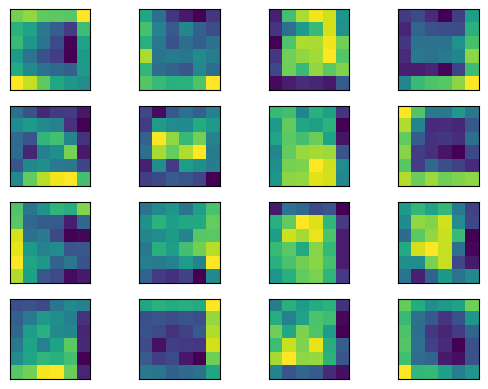

<Figure size 1200x800 with 0 Axes>

In [25]:
#11) 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

- 즉, 출력층에 가까울수록 원래 형태는 찾아볼 수 없고, 이미지 특징들만 전달됨